In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.light57_hparams import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Thu Mar 11 17:18:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:2E:00.0 Off |                  N/A |
| 99%   87C    P2   202W / 250W |  10340MiB / 11016MiB |     79%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:2F:00.0 Off |                  N/A |
| 58%   

In [3]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/rubato/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done
done


In [4]:
save_dir = '/data/save/light57_model'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [5]:
!ls $save_dir

data.json  save_71436


In [7]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 71436

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 283.0MiB
TTS size 195.3MiB
MelEncoder size 65.3MiB
MelDecoder size 119.0MiB
loaded : 71436
71436
done


In [8]:
trainset = LJDataset(tts_hparams)
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=8, #tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(train_loader)

validset = LJDataset(tts_hparams, split='valid')
valid_loader = torch.utils.data.DataLoader(validset, num_workers=tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(valid_loader)

testset = LJDataset(tts_hparams, split='test')
test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [9]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.031199550628662108


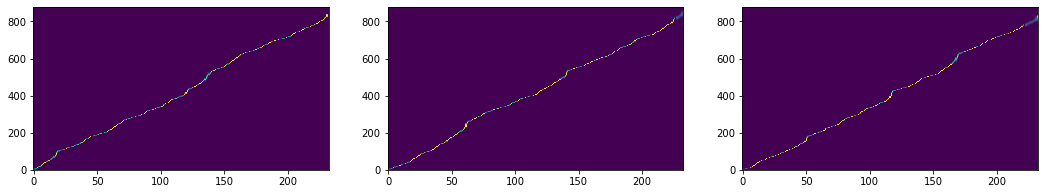

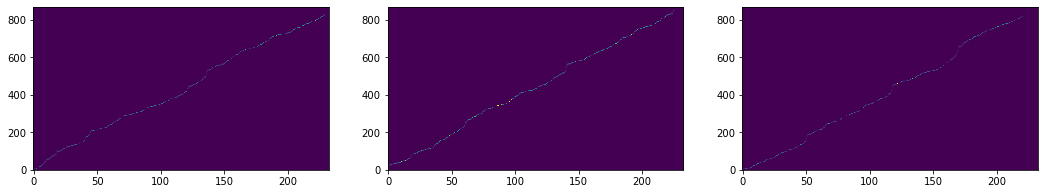

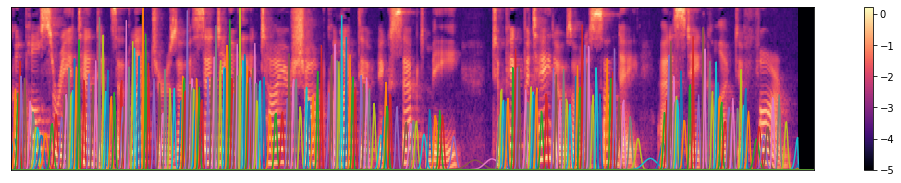

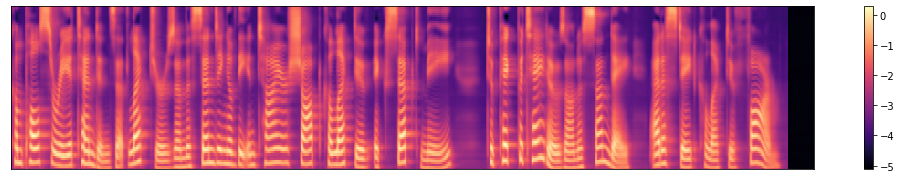

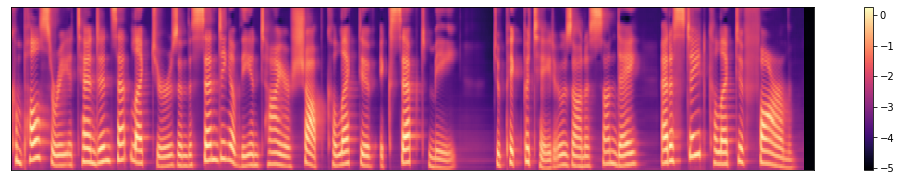

tensor(0.2883, device='cuda:0')
step : 73001 stt : 0.0016 tts : 0.1660 recon : 0.0285 kl : 0.0085 beta : 1.0000
tensor(0.1944, device='cuda:0')
step : 73002 stt : 0.0014 tts : 0.1620 recon : 0.0293 kl : 0.0088 beta : 1.0000
tensor(0.2599, device='cuda:0')
step : 73003 stt : 0.0011 tts : 0.1594 recon : 0.0257 kl : 0.0080 beta : 1.0000
tensor(0.2355, device='cuda:0')
step : 73004 stt : 0.0015 tts : 0.1626 recon : 0.0269 kl : 0.0082 beta : 1.0000
tensor(0.1994, device='cuda:0')
step : 73005 stt : 0.0019 tts : 0.1633 recon : 0.0281 kl : 0.0087 beta : 1.0000
tensor(0.2269, device='cuda:0')
step : 73006 stt : 0.0010 tts : 0.1534 recon : 0.0260 kl : 0.0082 beta : 1.0000
tensor(0.2092, device='cuda:0')
step : 73007 stt : 0.0012 tts : 0.1693 recon : 0.0276 kl : 0.0085 beta : 1.0000
tensor(0.2403, device='cuda:0')
step : 73008 stt : 0.0010 tts : 0.1537 recon : 0.0281 kl : 0.0085 beta : 1.0000
tensor(0.2251, device='cuda:0')
step : 73009 stt : 0.0013 tts : 0.1578 recon : 0.0256 kl : 0.0081 beta :

tensor(0.2348, device='cuda:0')
step : 73075 stt : 0.0011 tts : 0.1603 recon : 0.0276 kl : 0.0089 beta : 1.0000
tensor(0.1901, device='cuda:0')
step : 73076 stt : 0.0005 tts : 0.1613 recon : 0.0270 kl : 0.0087 beta : 1.0000
tensor(0.2678, device='cuda:0')
step : 73077 stt : 0.0011 tts : 0.1627 recon : 0.0264 kl : 0.0085 beta : 1.0000
tensor(0.2331, device='cuda:0')
step : 73078 stt : 0.0010 tts : 0.1732 recon : 0.0290 kl : 0.0091 beta : 1.0000
tensor(0.2053, device='cuda:0')
step : 73079 stt : 0.0013 tts : 0.1777 recon : 0.0314 kl : 0.0095 beta : 1.0000
tensor(0.2930, device='cuda:0')
step : 73080 stt : 0.0012 tts : 0.1729 recon : 0.0294 kl : 0.0091 beta : 1.0000
tensor(0.2255, device='cuda:0')
step : 73081 stt : 0.0011 tts : 0.1722 recon : 0.0319 kl : 0.0093 beta : 1.0000
tensor(0.2605, device='cuda:0')
step : 73082 stt : 0.0015 tts : 0.1583 recon : 0.0246 kl : 0.0078 beta : 1.0000
tensor(0.6132, device='cuda:0')
step : 73083 stt : 0.0033 tts : 0.1663 recon : 0.0269 kl : 0.0084 beta :

KeyboardInterrupt: 

In [10]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta)
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta)    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 3
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
            batch_size = _tts_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
            batch_size = _stt_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 100)
                
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _y = tts_outputs['pred'].data.cpu().numpy()
            librosa.display.specshow(_y[index])
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _s = samples.data.cpu().numpy()
            librosa.display.specshow(_s[index, :, :_y.shape[2]])
            plt.colorbar()
            plt.show()
                      
        step += 1
        

In [11]:
logger.save(step, model, optimizer)

saved /data/save/light57_model/save_73098


The day passed in revelry and drunkenness. Although spirituous liquors were forbidden,
torch.Size([1, 80, 461]) 0.011259007453918456
{'alignment': 0.0004630088806152344, 'random': 0.000263214111328125, 'last_conv': 0.00441431999206543, 'z_proj': 0.0002453327178955078, 'cond': 0.0008161067962646484, 'up': 0.00035881996154785156, 'encode': 0.0036704540252685547, 'pad': 3.552436828613281e-05, 'enc_conv': 0.000782012939453125, 'enc_lstm': 0.002684354782104492}


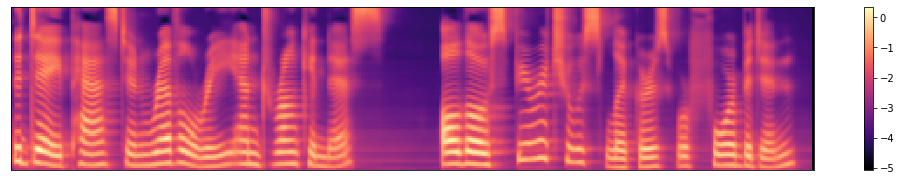

In [35]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if i == 8:
        break
print(batch['strings'][0])

model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _x = batch['mels'].data.cpu().numpy()
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [36]:
vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

(118016,)
